In [1]:
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms

from retinanet import model
import pytorch_lightning
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
logger = TensorBoardLogger("./runs", name = "retinanet")
retinanet = model.resnet50(80)
retinanet.load_state_dict(torch.load("./coco_resnet_50_map_0_335_state_dict.pt"))

<All keys matched successfully>

In [4]:
retinanet
torch.save(retinanet, "retinanet_pretrained.pt")

del retinanet

Using cache found in /home/datnguyenthanh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-7 Python-3.8.16 torch-1.7.1+cu110 CUDA:0 (GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


before .pandas(): image 1/1: 640x640 5 dogs
Speed: 10.9ms pre-process, 576.2ms inference, 3.4ms NMS per image at shape (1, 3, 640, 640)
after .pandas():          xmin        ymin        xmax        ymax  confidence  class name
0  477.409546  271.200928  639.309448  471.466492    0.863320     16  dog
1  240.979187  232.631226  373.758362  430.937256    0.792796     16  dog
2    0.000000  274.355408  200.237457  469.587891    0.757464     16  dog
3  364.173981  299.389221  497.903778  458.904297    0.727706     16  dog
4  160.265961  297.840607  273.364197  437.075958    0.419707     16  dog
after to_dict: {'xmin': {0: 477.4095458984375, 1: 240.97918701171875, 2: 0.0, 3: 364.1739807128906, 4: 160.26596069335938}, 'ymin': {0: 271.200927734375, 1: 232.6312255859375, 2: 274.35540771484375, 3: 299.38922119140625, 4: 297.8406066894531}, 'xmax': {0: 639.3094482421875, 1: 373.75836181640625, 2: 200.23745727539062, 3: 497.9037780761719, 4: 273.36419677734375}, 'ymax': {0: 471.46649169921875, 1: 

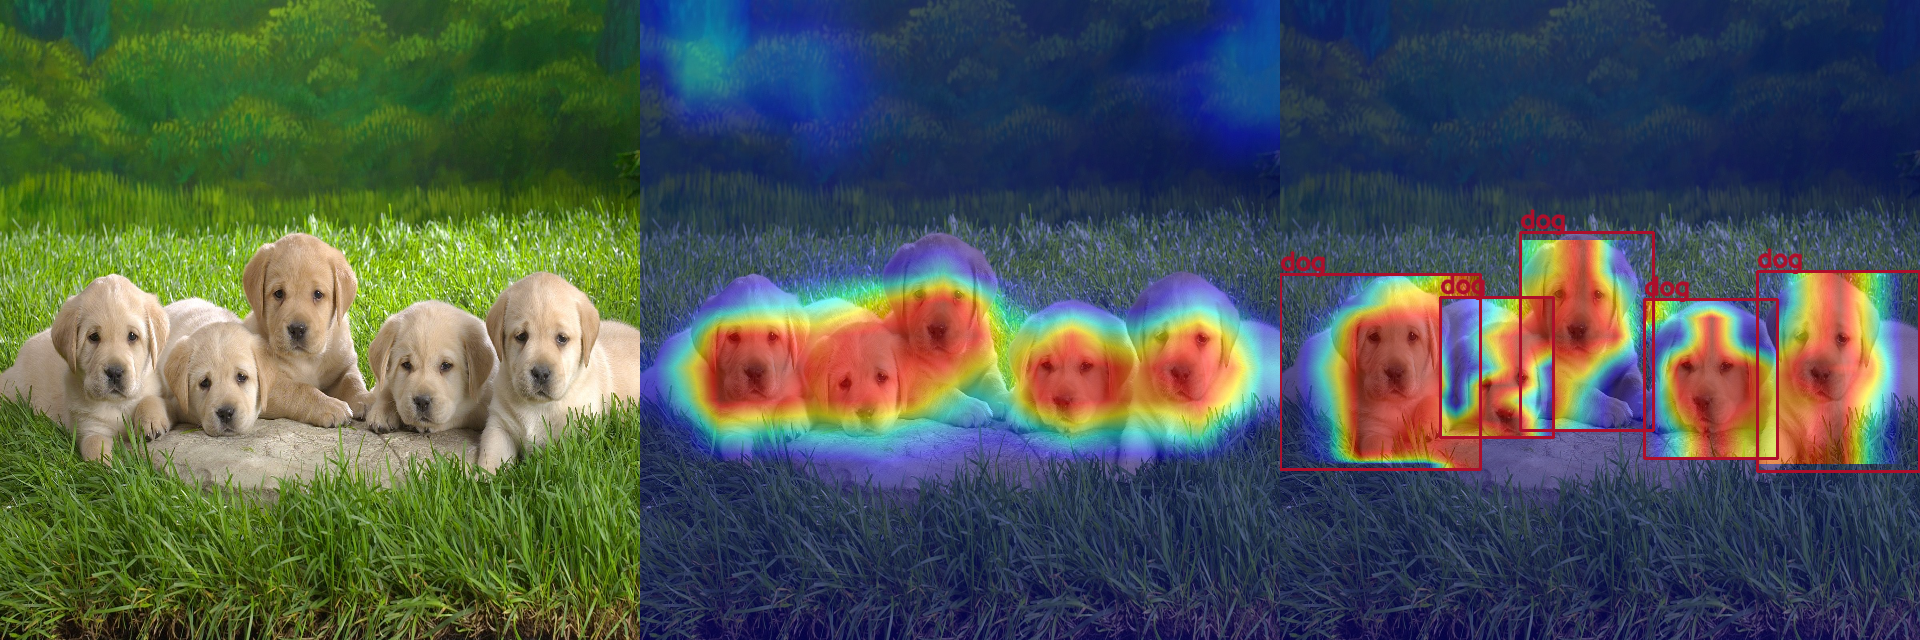

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    print(f"before .pandas(): {results}")
    detections = results.pandas().xyxy[0]
    print(f"after .pandas(): {detections}")
    detections = detections.to_dict()
    print(f"after to_dict: {detections}")
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
img = np.array(Image.open("./data/Puppies_(4984818141).jpg"))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())

cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)

Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))


In [24]:
model.model.model.model[-2]

C3(
  (cv1): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)

In [6]:
import pandas as pd

classes = """person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush"""
class_lst = classes.split("\n")
cat_ids = list(range(len(class_lst)))
df = pd.DataFrame({"class": class_lst, "id": cat_ids})
df.to_csv("class_mapping.csv", header=False, index=False)

In [7]:
import torch
import numpy as np
import time
import os
import csv
import cv2
import argparse


def load_classes(csv_reader):
    result = {}

    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
        class_id = int(class_id)

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


# Draws a caption above the box in an image
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

def detect_image(image_path, model_path, class_list):

    with open(class_list, 'r') as f:
        classes = load_classes(csv.reader(f, delimiter=','))

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    model = torch.load(model_path)

    if torch.cuda.is_available():
        model = model.cuda()

    model.training = False
    model.eval()

    for img_name in os.listdir(image_path):

        image = cv2.imread(os.path.join(image_path, img_name))
        if image is None:
            continue
        image_orig = cv2.resize(image.copy(), (640,640))

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        min_side = 608
        max_side = 1024
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        # image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
        image = cv2.resize(image, (640, 640))
        rows, cols, cns = image.shape

        pad_w = 32 - rows % 32
        pad_h = 32 - cols % 32

        new_image = np.zeros((rows, cols, cns)).astype(np.float32)
        # new_image = np.zeros((640, 640, 3)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)
        image = new_image.astype(np.float32)
        image /= 255
        image -= [0.485, 0.456, 0.406]
        image /= [0.229, 0.224, 0.225]
        image = np.expand_dims(image, 0)
        image = np.transpose(image, (0, 3, 1, 2))

        lbs, bboxes = [], []
        with torch.no_grad():

            image = torch.from_numpy(image)
            if torch.cuda.is_available():
                image = image.cuda()

            st = time.time()
            print(image.shape, image_orig.shape, scale)
            scores, classification, transformed_anchors = model(image.cuda().float())
            print('Elapsed time: {}'.format(time.time() - st))
            idxs = np.where(scores.cpu() > 0.5)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]

                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                label_name = labels[int(classification[idxs[0][j]])]
                lbs.append(label_name)
                bboxes.append(bbox)
                print(bbox, classification.shape)
                score = scores[j]
                caption = '{} {:.3f}'.format(label_name, score)
                # draw_caption(img, (x1, y1, x2, y2), label_name)
                draw_caption(image_orig, (x1, y1, x2, y2), caption)
                cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

            return image_orig, lbs, bboxes, model, image


torch.Size([1, 3, 640, 640]) (640, 640, 3) 0.5066666666666667
Elapsed time: 0.09862089157104492
tensor([  0.51538, 272.20428, 178.82260, 465.62427], device='cuda:0') torch.Size([46])
tensor([472.73013, 270.56595, 638.72693, 477.67075], device='cuda:0') torch.Size([46])
tensor([239.43277, 230.29611, 368.18088, 430.61349], device='cuda:0') torch.Size([46])
tensor([360.05542, 299.53662, 496.03436, 432.63428], device='cuda:0') torch.Size([46])
tensor([158.77100, 296.19934, 265.98285, 436.12109], device='cuda:0') torch.Size([46])
tensor([166.77766, 278.39633, 358.68567, 432.19559], device='cuda:0') torch.Size([46])


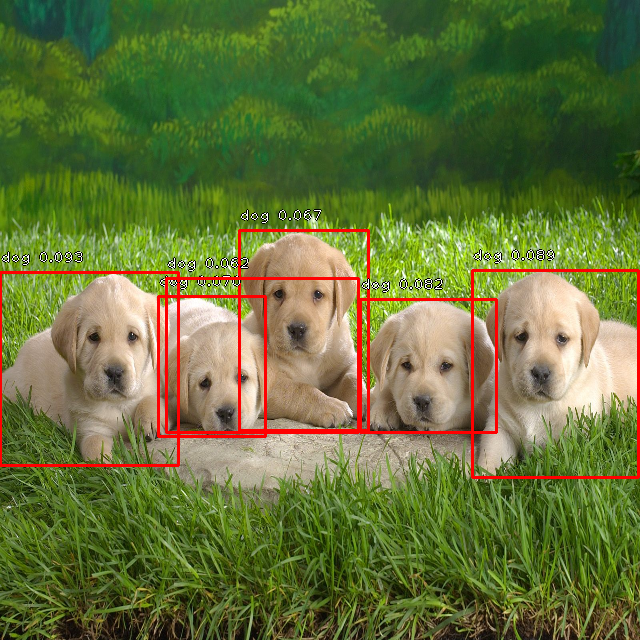

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

img, labels_lst, bbox_lst, retinanet, tensor_test = detect_image("./data", "./retinanet_pretrained.pt", "./class_mapping.csv")
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
image_float_np = img / 255

In [10]:
image_float_np.shape

(640, 640, 3)

In [11]:
def retinanet_reshape_transform(x):
    #print(x.shape)
    print(x[0].size)
    target_size = x[0].size()[-2 : ]
    print(target_size)
    activations = []
    for value in x:
        activations.append(torch.nn.functional.interpolate(value, target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations


In [12]:
import torchvision
class RetinanetBBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs[2]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs[2])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs[1][index] == label:
                score = ious[0, index] + model_outputs[0][index]
                output = output + score
        return output

<built-in method size of Tensor object at 0x7f9038148180>
torch.Size([80, 80])


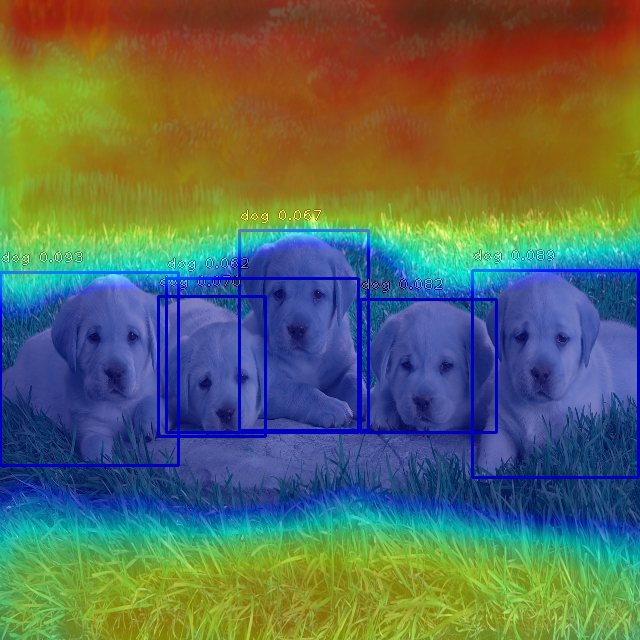

In [13]:
target_layers = [retinanet.classificationModel.]
retinanet.eval()
targets = [RetinanetBBoxScoreTarget(labels=labels_lst, bounding_boxes=bbox_lst)]
cam = EigenCAM(retinanet, 
               target_layers, 
               use_cuda=True, 
               reshape_transform=retinanet_reshape_transform,
               )
grayscale_cam = cam(tensor_test, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
del grayscale_cam
Image.fromarray(cam_image)


In [25]:
retinanet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
from pytorch_grad_cam.ablation_layer import AblationLayer

class AblationLayerRetinanet(AblationLayer):
    def __init__(self):
        super(AblationLayerRetinanet, self).__init__()
        
    def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
        self.activations = []
        for index, value in enumerate(activations):
            fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
            self.activations[index] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)
            
        def __call__(self, x):
            result = self.activations
            layers = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
            num_channels_to_ablate = result[4].size(0)
            for i in range(num_channels_to_ablate):
                pyramid_layer = int(self.indices[i] / 80)
                index_in_pyramid_layer = int(self.indicies[i] % 80)
                result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
            return result

In [15]:
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
cam = AblationCAM(retinanet,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=retinanet_reshape_transform,
               ablation_layer=AblationLayerRetinanet())

grayscale_cam = cam(tensor_test, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))


<built-in method size of Tensor object at 0x7f9038101a80>
torch.Size([80, 80])
<built-in method size of Tensor object at 0x7f914fbe6480>
torch.Size([80, 80])


TypeError: len() of a 0-d tensor